In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")
from itertools import cycle
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import random
from sklearn import tree
import pydotplus
import scipy.stats as stats
import timeit
from sklearn.utils import column_or_1d 
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,\
 classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble

In [96]:
df_o = pd.read_csv('2019_04.csv')
df_o.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-04-01,4393,1.0,Long Branch,74,Long Branch,74,2019-04-02 00:08:00,2019-04-02 00:07:06,0.000000,departed,No Jersey Coast,NJ Transit
1,2019-04-01,4393,2.0,Long Branch,74,Elberon,40,2019-04-02 00:12:00,2019-04-02 00:13:09,1.150000,departed,No Jersey Coast,NJ Transit
2,2019-04-01,4393,3.0,Elberon,40,Allenhurst,4,2019-04-02 00:16:00,2019-04-02 00:18:07,2.116667,departed,No Jersey Coast,NJ Transit
3,2019-04-01,4393,4.0,Allenhurst,4,Asbury Park,8,2019-04-02 00:20:00,2019-04-02 00:21:12,1.200000,departed,No Jersey Coast,NJ Transit
4,2019-04-01,4393,5.0,Asbury Park,8,Bradley Beach,22,2019-04-02 00:23:00,2019-04-02 00:23:10,0.166667,departed,No Jersey Coast,NJ Transit


In [97]:
df_o.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,213163.000000,238693.000000,238693.000000,213163.000000
mean,8.200063,4199.830297,4208.931670,3.697638
std,5.108761,11739.567890,11749.484752,4.768392
min,1.000000,1.000000,1.000000,0.000000
25%,4.000000,61.000000,61.000000,1.100000
50%,8.000000,105.000000,105.000000,2.350000
75%,12.000000,137.000000,137.000000,4.916667
max,26.000000,43599.000000,43599.000000,163.000000


In [98]:
df=df_o.sample(n=5000)

In [99]:
df.dtypes

date               object
train_id           object
stop_sequence     float64
from               object
from_id             int64
to                 object
to_id               int64
scheduled_time     object
actual_time        object
delay_minutes     float64
status             object
line               object
type               object
dtype: object

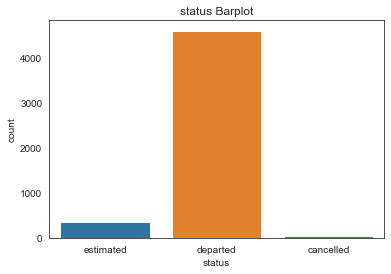

In [100]:
plt.title("status Barplot")
sns.countplot(x="status", data=df)

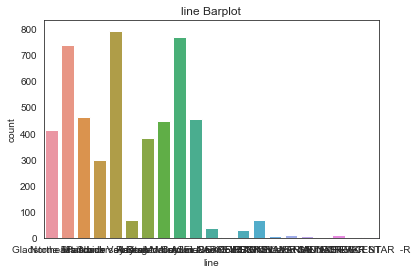

In [101]:
plt.title("line Barplot")
sns.countplot(x="line", data=df)

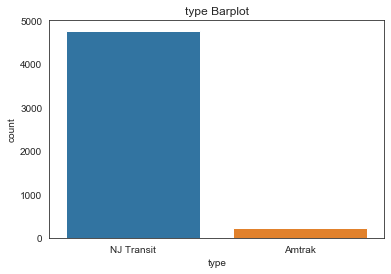

In [102]:
plt.title("type Barplot")
sns.countplot(x="type", data=df)

In [103]:
df = df.drop(['date','train_id','stop_sequence','from','to','scheduled_time','actual_time','line'], 1)

In [104]:
df['status'] = df['status'].map({'departed': 2, 'estimated status': 1, 'cancelled': 0})
df['type'] = df['type'].map({'NJ Transit': 1, 'Amtrak': 0})
df.head()

,from_id,to_id,delay_minutes,status,type
23719,117,49,2.000000,NaN,1
65590,125,107,3.416667,2.0,1
66592,99,104,0.266667,2.0,1
97092,112,61,1.250000,2.0,1
87570,125,103,11.116667,2.0,1


In [105]:
columns = df[['from_id','to_id','delay_minutes','status','type']]

for column in columns: 
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [106]:
df.dtypes

from_id            int64
to_id              int64
delay_minutes    float64
status           float64
type               int64
dtype: object

## Missing value

In [107]:
df.isnull().sum()*100/df.isnull().count()

from_id          0.00
to_id            0.00
delay_minutes    9.86
status           7.18
type             0.00
dtype: float64

In [108]:
df = df.dropna(axis=0,how='any') #drop all rows that have any NaN values

## Normalization: Preprocessing

In [109]:
X = df.drop(['status'],1)
Y = df.drop(['from_id','to_id','delay_minutes','type'],1)

In [110]:
X_normalized = normalize(X)
X_normalized_df = pd.DataFrame(normalize(X), columns = X.columns)
X_normalized_df.dtypes

from_id          float64
to_id            float64
delay_minutes    float64
type             float64
dtype: object

In [111]:
X_normalized_df['from_id'] = np.float16(X_normalized_df['from_id'])
X_normalized_df['to_id'] = np.float16(X_normalized_df['to_id'])
X_normalized_df['delay_minutes'] = np.float16(X_normalized_df['delay_minutes'])
X_normalized_df['type'] = np.float16(X_normalized_df['type'])
X_normalized_df.dtypes

from_id          float16
to_id            float16
delay_minutes    float16
type             float16
dtype: object

In [113]:
#Use silhouette score
range_n_clusters = list (range(2,7))
print ("Number of clusters from 2 to 6: \n", range_n_clusters)
for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_normalized_df)
    centers = clusterer.cluster_centers_
    score = silhouette_score (X_normalized_df, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

Number of clusters from 2 to 6: 
 [2, 3, 4, 5, 6]
For n_clusters = 2, silhouette score is 0.5606741991248474
For n_clusters = 3, silhouette score is 0.618476631351351
For n_clusters = 4, silhouette score is 0.6057011018515441
For n_clusters = 5, silhouette score is 0.6262456588182455
For n_clusters = 6, silhouette score is 0.6192663468290768


From here, we can see that 5 clusters may be the best choose.

## K-Means

In [114]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10)
Y_pred = km.fit_predict(X_normalized_df)
Y_pred

array([4, 4, 0, ..., 0, 2, 3])

In [115]:
df["Cluster"]=Y_pred
df.head()

,from_id,to_id,delay_minutes,status,type,Cluster
65590,125,107,3.416667,2.0,1,4
66592,99,104,0.266667,2.0,1,4
97092,112,61,1.250000,2.0,1,0
87570,125,103,11.116667,2.0,1,4
160918,58,52,3.016667,2.0,1,4


In [116]:
df = df.sort_values(['Cluster'])
df

,from_id,to_id,delay_minutes,status,type,Cluster
93945,140,81,4.100000,2.0,1,0
236208,136,87,4.216667,2.0,1,0
133812,141,79,4.000000,2.0,1,0
157796,75,33,2.633333,2.0,1,0
132959,116,58,2.583333,2.0,1,0
...,...,...,...,...,...,...
199100,104,99,6.166667,2.0,1,4
73883,153,152,2.333333,2.0,1,4
170530,91,92,5.216667,2.0,1,4
58235,69,98,2.466667,2.0,1,4


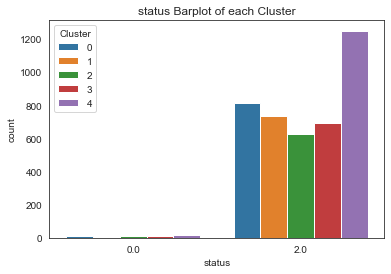

In [129]:
plt.title("status Barplot of each Cluster")
sns.countplot(x="status",hue="Cluster", data=df)

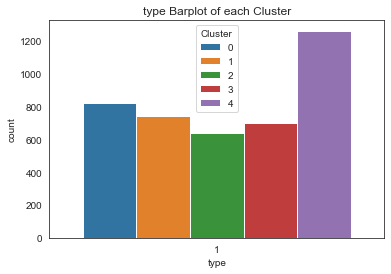

In [131]:
plt.title("type Barplot of each Cluster")
sns.countplot(x="type",hue="Cluster", data=df)

## Supervised 

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized_df, Y, test_size=0.4, random_state=0)

### Model 1: Decision Tree Model

In [133]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0)
dtmodel=decision_tree.fit(X_train,Y_train)
decision_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

#### Cross validation

In [134]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores.mean())

0.9863999999999999


#### Classification_report and Confusion matrix

In [135]:
Y_pred = dtmodel.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Decision Tree Model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Decision Tree Model Classification report:
Accuracy:  0.9886091127098321
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         2.0       1.00      0.99      0.99      1667

    accuracy                           0.99      1668
   macro avg       0.50      0.49      0.50      1668
weighted avg       1.00      0.99      0.99      1668

Confusion matrix:
[[   0   18]
 [   1 1649]]


### Model 2: Random forest model

In [136]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

,feature,importance
0,type,0.296535
1,to_id,0.254603
2,from_id,0.241384
3,delay_minutes,0.207479


#### Cross validation

In [137]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores.mean())

0.9827999999999999


#### Classification_report and Confusion matrix

In [138]:
Y_pred = dtmodel_R.predict(X_test) 
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Random forest model Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Random forest model Classification report:
Accuracy:  0.999400479616307
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        17
         2.0       1.00      1.00      1.00      1651

    accuracy                           1.00      1668
   macro avg       0.97      1.00      0.99      1668
weighted avg       1.00      1.00      1.00      1668

Confusion matrix:
[[  17    1]
 [   0 1650]]


## Conclusion

For unsupervised learning, we got the silhouette score for each number of cluster from 2 to 6 and the score reaches the maximum value at n = 5. So we decide to use n = 5 to do the K-Means cluster. We show the barplot of status and type for each cluster. From these barplots, we can see that the Cluster4 contains the most observations and the Cluster2 contains the least observations. For the other clusters, we don't see any obvious features of them.

For supervised learning, we decided to use 'status' to classfy our dataset. We used two models: Decision Tree Model and Random forest model. And we also do show the cross validation, Classification_report and Confusion matrix for each model. From the result, we can conclude that the result of the classification is perfect. We got  good cross validation score, accuracy and confusion matrix.